## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: "Евгений Онегин"


In [2]:
if not os.path.exists('data/onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('data/onegin.txt', 'r', encoding='utf-8') as iofile:
    raw_text = iofile.readlines()
    
raw_text = [x.replace('\t\t', '') for x in raw_text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(raw_text).lower()

### Tokenizing

Assign index to every token (character) in `text`

In [4]:
tokens = sorted(set(text))
print("Unique tokens: ", len(tokens))

Unique tokens:  83


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

Various helper functions to process data:

In [6]:
import numpy as np

In [7]:
def divide_into_samples(text, 
                        sample_length, 
                        num_samples=None, 
                        batch_first=True):
    '''
    The function divides `text` into samples of `sample_length`
    
    :param text: text string to divide in samples
    :param Sample_length: length of single sample
    :param num_samples: number of samples,
        (default `len(text)//sample_length`, 
        maximum `len(text)//sample_length`)
    :param batch_first: function returns [batch,time] if `True` 
        [time,batch] if `False`
    
    :return: numpy array of shape `(num_samples, sample_length)` 
        - samples from text
    '''
    max_samples = len(text)//sample_length
    if num_samples:
        assert num_samples <= max_samples,\
            'Provided number of samples exceeds maximum'
    
    num_samples = num_samples or max_samples
    
    samples = np.zeros([num_samples, sample_length])
    
    for i in range(num_samples):
        start_idx = i*sample_length
        samples[i:]=[token_to_idx[token] for token in 
                     text[start_idx : start_idx+sample_length]]
        
    if not batch_first: # convert [batch, time] into [time, batch]
        samples = np.transpose(samples)
    
    return samples


def take_random_samples(samples, num_samples, batch_first=True):
    '''
    Take random samples from provided array
    
    Uses `numpy.random.randint()`
    :param samples: numpy array of shape `(num_samples, sample_length)` 
        - samples for randomizing
    :param num_samples: number of samples to generate
    :param batch_first: function returns [batch,time] if `True` 
        [time,batch] if `False`
    
    :return: numpy array of shape `(num_samples, sample_length)`
        - randomly taken samples
    '''
    if batch_first:
        return samples[np.random.randint(0, 
                                         samples.shape[0], 
                                         num_samples
                                        ).astype(int), :]
    else:
        return samples[:, np.random.randint(0, 
                                            samples.shape[-1], 
                                            num_samples
                                           ).astype(int)]
    
    
def sample_to_string(sample):
    '''
    Convert sample to string
    
    :param sample: sample to convert
    
    :return: string, sample converted using `idx_to_token`
    '''
    return "".join(np.vectorize(lambda x: idx_to_token[x])(sample))

See how it works:

In [8]:
samples_example = divide_into_samples(text, 200)
samples_example

array([[ 0., 26.,  0., ...,  1., 59., 63.],
       [66., 59., 49., ..., 49., 59., 54.],
       [ 1., 60., 59., ...,  5.,  1., 49.],
       ...,
       [63., 72.,  5., ..., 58., 50., 54.],
       [ 1., 59., 58., ...,  1., 63., 50.],
       [ 1., 49., 45., ..., 60., 59., 56.]])

In [9]:
for s in samples_example[:2]:
    print("[", sample_to_string(s), "]")

[ 
i

«мой дядя самых честных правил,
когда не в шутку занемог,
он уважать себя заставил
и лучше выдумать не мог.
его пример другим наука;
но, боже мой, какая скука
с больным сидеть и день и ночь,
не от ]
[ ходя ни шагу прочь!
какое низкое коварство
полуживого забавлять,
ему подушки поправлять,
печально подносить лекарство,
вздыхать и думать про себя:
когда же черт возьмет тебя!»



ii

так думал молодой ]


In [10]:
for s in take_random_samples(samples_example, 2):
    print("[", sample_to_string(s), "]")

[ бленной, бедной и простой,
но равнодушною княгиней,
но неприступною богиней
роскошной, царственной невы.
о люди! все похожи вы
на прародительницу эву:
что вам дано, то не влечет;
вас непрестанно змий  ]
[  неугомонно
хлопочем, судим обо всем,
что пылких душ неосторожность
самолюбивую ничтожность
иль оскорбляет, иль смешит,
что ум, любя простор, теснит,
что слишком часто разговоры
принять мы рады за дел ]


### Building the model

Now we want to build and train recurrent neural net which would be able to write something similar to Pushkin's text.

Let's use vanilla RNN, similar to the one created during the lesson.

In [11]:
import torch, torch.nn as nn, torch.nn.functional as F
# set PyTorch to create all tensors on nvidia gpu if any
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

Define single cell of RNN as a torch module

In [12]:
class RNNModelCell(nn.Module):
    '''
    Single cell of RNN
    
    Embedding layer is applied to the input of the cell
    '''
    def __init__(self, hidden_size, num_tokens, embedding_size=18):
        '''
        Create new RNN cell
        
        :param hidden_size: size of hidden vector
        :param num_tokens: number of unique tokens to embed
        :param embedding_size: size of dense output of embedding layer
        '''
        super(self.__class__,self).__init__()
        self.hidden_size = hidden_size
        
        # Embedding layer to convert token index to vector
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        # Linear conversion from input and hidden vector concatenated
        # to hidden vector 
        self.i2h = nn.Linear(hidden_size + embedding_size, hidden_size)
        # Linear conversion from hidden vector to output logits
        self.h2l = nn.Linear(hidden_size, num_tokens)
        # tanh activation function
        self.tanh = torch.nn.Tanh()
        
        
    def forward(self, x_next, hidden):
        '''
        Define the computation performed at every call
        
        :param x_next: x vector at next step
        :param hidden: hidden vector from previous step
        
        :return h_next: hidden vector at next step
        :return logits: logits vector at this step
        '''
        #embedd x_next
        x_embedded = self.embedding(x_next)
        # combine input and hidden state
        input_combined = torch.cat([x_embedded, hidden], dim=-1)
        h_next = self.i2h(input_combined)
        # apply nonlinearity
        h_next = self.tanh(h_next)
        # compute logits
        logits = self.h2l(h_next)
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        '''
        Initial state of hidden vector
        
        :param batch_size: size of batch input
        
        :return: initial hidden vector (all zeros)
        '''
        return torch.zeros(batch_size, 
                           self.hidden_size, 
                           requires_grad=True)

To complete RNN we will loop through time while feeding output of previous cell to the next one

In [13]:
def rnn_loop(char_rnn, batch_idx):
    '''  
    Batch compute logits for each character
    :param batch_idx: int64 torch.tensor of shape [batch_size, time]
    '''
    batch_size, sample_length = batch_idx.size()
    # initial state of model
    hidden = char_rnn.initial_state(batch_size)
    logits = []
    
    # take batch of next characters
    for x_t in batch_idx.transpose(0,1):
        # and feed it to cell
        hidden, logits_next = char_rnn(x_t, hidden)
        logits.append(logits_next)
    
    return torch.stack(logits, dim=1)

#### Checking output

Let's check that our model handles input/output correctly

In [14]:
num_tokens = len(tokens)
hidden_size = 128

t_char_rnn = RNNModelCell(hidden_size, num_tokens)

In [15]:
batch_idx = torch.tensor(divide_into_samples(text, 20, 1), 
                         dtype=torch.int64)
batch_idx.transpose(0,1)

tensor([[ 0],
        [26],
        [ 0],
        [ 0],
        [43],
        [57],
        [59],
        [54],
        [ 1],
        [49],
        [76],
        [49],
        [76],
        [ 1],
        [62],
        [45],
        [57],
        [72],
        [66],
        [ 1]], device='cuda:0')

In [16]:
logit_seq = rnn_loop(t_char_rnn, batch_idx)
logit_seq

tensor([[[-0.1267,  0.1321, -0.0303,  ..., -0.0635, -0.2055,  0.0176],
         [-0.1391,  0.0194, -0.1476,  ...,  0.0706, -0.2403, -0.0180],
         [-0.1418,  0.1997, -0.0337,  ..., -0.1430, -0.1324,  0.0316],
         ...,
         [-0.0960, -0.1683, -0.2788,  ...,  0.1626,  0.0685,  0.0769],
         [-0.0875,  0.0560, -0.2150,  ...,  0.1001,  0.0612,  0.0371],
         [ 0.1266,  0.1540,  0.0176,  ..., -0.0306, -0.1360,  0.2728]]],
       device='cuda:0', grad_fn=<StackBackward0>)

#### Training loop

In [17]:
import matplotlib.pyplot as plt
# use `tqdm` to display progress bar
from tqdm import tqdm
# clear output for real time plot
from IPython.display import clear_output

In [18]:
# common model hyperparameters
hidden_size = 128

# common training parameters
# 400 is the average verse length
sample_length = 400
batch_size = 32
num_epochs = 1500

In [19]:
# Data for this loop
my_tokens = tokens
my_text = text
num_tokens = len(my_tokens)

# should loss function be plotted in real time
real_time_plot = True
# plot interval in epochs if True
plot_int = 10

# model, optimizer and loss function
char_rnn = RNNModelCell(hidden_size, num_tokens)
opt_rnn = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss()

# prepare the samples
samples = divide_into_samples(my_text, sample_length)

# list to record loss history
history_rnn=[]

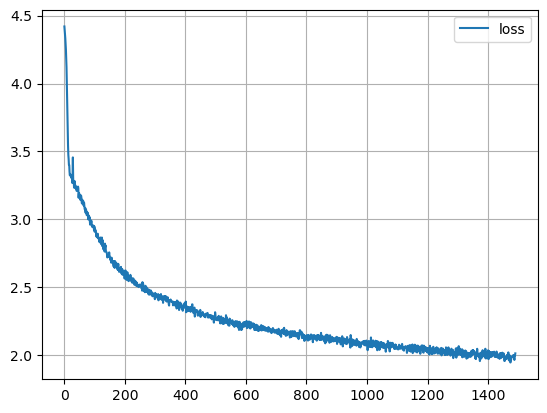

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [08:48<00:00,  2.84it/s]


In [20]:
# main training loop
for i in tqdm(range(num_epochs)):
    
    # prepare random samples
    batch_idx = torch.tensor(take_random_samples(samples, batch_size), 
                             dtype=torch.int64)
    
    # run the model
    logits_seq = rnn_loop(char_rnn, batch_idx)
    
    # for every time step logit is a prediction
    # for the next step, so we will shift it
    # to the right
    predictions = logits_seq[:, :-1]
    # and slice corresponding part of our data as 
    # "train" data
    next_tokens = batch_idx[:, 1:]

    # compute loss function
    loss = loss_func(
        # bring parameters first dimensions to same shape
        predictions.reshape(-1, num_tokens),
        next_tokens.reshape(-1)
    )
    
    # copy loss from gpu and save it
    history_rnn.append(loss.data.cpu().numpy())
    
    # plot loss in real time
    if real_time_plot and i%plot_int==0:
        clear_output(True)
        fig, ax = plt.subplots()
        ax.plot(history_rnn, label="loss")
        ax.legend()
        ax.grid(True)
        plt.show()
    
    # perform optimizer step
    loss.backward()
    opt_rnn.step()   
    opt_rnn.zero_grad()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

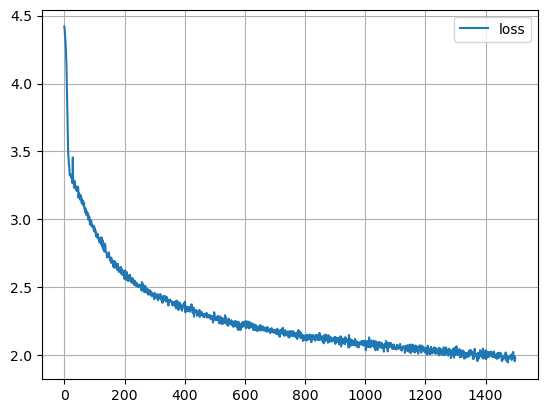

In [21]:
fig, ax = plt.subplots()
ax.plot(history_rnn, label="loss")
ax.legend()
ax.grid(True)

#### Generating samples

In [22]:
def generate_sample_rnn(char_rnn, 
                        idx_to_token, 
                        seed_phrase='hello', 
                        length=1000, 
                        temperature=1.0):
    '''
    The function generates text given a phrase.
    
    :param idx_to_token: index to token mapping
    :param seed_phrase: prefix characters. The RNN is asked to continue
        the phrase
    :param length: output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature 
        produces more chaotic outputs, smaller temperature converges to 
        the single most likely output.
        
    :return: generated phrase
        
    Be careful with the model output. This model waits logits 
    (not probabilities/log-probabilities) of the next symbol.
    '''
    
    num_tokens = len(idx_to_token)
    # convert seed phrase to tokens
    seed_phrase = seed_phrase.lower()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    # initialize model state with zeros
    hid_state = char_rnn.initial_state(batch_size=1)
    
    # feed the seed phrase, if any, one charachter at a time
    for i in tqdm(range(len(seed_phrase) - 1), desc="seeding:"):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    # start generating
    for _ in tqdm(range(length - len(seed_phrase)), desc="generation:"):
        
        # feed last character to model
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # apply activation function
        p_next = \
            F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([idx_to_token[ix] for ix in \
                    x_sequence.data.cpu().numpy()[0]])

Let's try generating some text

In [23]:
print(generate_sample_rnn(char_rnn, 
                          idx_to_token, 
                          temperature=0.4, 
                          length=1000, 
                          seed_phrase="«мой дядя самых "))

generation:: 100%|█████████████████████████████████████████████████████████████████| 984/984 [00:00<00:00, 1477.48it/s]

«мой дядя самых давно,
постранный поравительный своей
с ней полово не стала
и в сердце когом от свор
она в тем своей мольша
сердце своей доловой
и привожить не старинный долго
не симилоский сторенья
и душа в полне толчать глузам,
признать не долой другой
не предругом над не странной,
и всё бедушно вечет горовой
всё не старинно не другой,
и смель стравнит сердце она сердца
мо в том перед уж ним сольбие сливеть
в души простанит она подала;
сердце он с не полвом и ветельны,
и в душа свое летом
и вам сердце полодной
со-старить с безнила своей их другой,
в том он взоро не был дорою
прительный придость не ставилась,
как полинет она в беденьем,
в свое полна, всех страсти странный,
как уж сердце не мни всех постала
и своей доловый от него
он свет он старала и старины
привот устало не стала,
и все другом половала,
пора старовительной всегда странье,
не с ней стразник на своей долго
не потрате стариный,
потам не старить не подной
не привлитьяна и был не всех не странный,
о пришен свои ставилась 

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Define single cell of RNN as a torch module

In [24]:
class LSTMModelCell(nn.Module):
    '''
    Single cell of LSTM
    
    Embedding layer is applied to the input of the cell
    '''
    def __init__(self, hidden_size, num_tokens, embedding_size=18):
        '''
        Create new LSTM cell
        
        :param hidden_size: size of hidden vector and memory vector
        :param num_tokens: number of unique tokens to embed
        :param embedding_size: size of dense output of embedding layer
        '''
        super(self.__class__,self).__init__()
        self.hidden_size = hidden_size
        
        # Embedding layer to convert token index to vector
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        # Linear conversion from input and hidden vector concatenated
        # to hidden vector 
        self.i2h = nn.Linear(hidden_size + embedding_size, hidden_size)
        # Linear conversion from memory vector to output logits
        self.h2l = nn.Linear(hidden_size, num_tokens)
        # Forget gate
        self.h2fg = nn.Linear(hidden_size, hidden_size)
        # Input gate
        self.h2ig = nn.Linear(hidden_size, hidden_size)
        # Output gate
        self.h2og = nn.Linear(hidden_size, hidden_size)
        # New memory content
        self.h2m = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x_next, hidden, memory):
        '''
        Define the computation performed at every call
        
        :param x_next: x vector at next step
        :param hidden: hidden vector from previous step
        :param memory: memory vector from previous step
        
        :return h_next: hidden vector at next step
        :return c_next: memory vector at next step
        :return logits: logits vector at this step
        '''
        #embedd x_next
        x_embedded = self.embedding(x_next)
        # combine input and hidden state
        input_combined = torch.cat([x_embedded, hidden], dim=-1)
        h_curr = self.i2h(input_combined)
        
        # load memory from previous step
        c_curr = memory
        
        # Compute forget gate
        f = F.sigmoid(self.h2fg(h_curr))
        
        # Compute input gate and new content
        i = F.sigmoid(self.h2ig(h_curr))
        c = F.tanh(self.h2m(h_curr))
        
        # Modify cell state
        c_next = f*c_curr + i*c
        
        # Compute output gate
        out = F.sigmoid(self.h2og(h_curr))
        
        # compute next hidden state
        h_next = out*F.tanh(c_next)
        # and logits
        logits = self.h2l(h_next)
        
        return h_next, c_next, logits
    
    def initial_state(self, batch_size):
        '''
        Initial state of hidden vector and memory
        
        :param batch_size: size of batch input
        
        :return hidden: initial hidden vector (all zeros)
        :return memory: initial memory vector (all zeros)
        '''
        return (
            torch.zeros(batch_size, 
                        self.hidden_size, 
                        requires_grad=True),
            torch.zeros(batch_size, 
                        self.hidden_size, 
                        requires_grad=True))


To complete RNN we will loop through time while next character is avaliable

In [25]:
def lstm_loop(char_lstm, batch_idx):
    '''    
    Batch compute logits for each character
    :param batch_idx: int64 torch.tensor of shape [batch_size, time]
    '''
    batch_size, sample_length = batch_idx.size()
    # initial state of model
    hidden, memory = char_lstm.initial_state(batch_size)
    logits = []
    
    # take batch of next characters
    for x_t in batch_idx.transpose(0,1):
        # and feed it to cell
        hidden, memory, logits_next = char_lstm(x_t, hidden, memory)
        logits.append(logits_next)
    
    return torch.stack(logits, dim=1)


#### Checking output

Let's check that our model handles input/output correctly

In [26]:
num_tokens = len(tokens)
hidden_size = 128

t_char_lstm = LSTMModelCell(hidden_size, num_tokens)

In [27]:
batch_idx = torch.tensor(divide_into_samples(text, 20, 1), 
                         dtype=torch.int64)
batch_idx.transpose(0,1)

tensor([[ 0],
        [26],
        [ 0],
        [ 0],
        [43],
        [57],
        [59],
        [54],
        [ 1],
        [49],
        [76],
        [49],
        [76],
        [ 1],
        [62],
        [45],
        [57],
        [72],
        [66],
        [ 1]], device='cuda:0')

In [28]:
logit_seq = lstm_loop(t_char_lstm, batch_idx)
logit_seq

tensor([[[ 0.0435,  0.1063,  0.0219,  ..., -0.0129, -0.0075, -0.0349],
         [ 0.0354,  0.1107,  0.0115,  ...,  0.0053, -0.0111, -0.0382],
         [ 0.0451,  0.1203,  0.0148,  ...,  0.0026, -0.0182, -0.0193],
         ...,
         [ 0.0197,  0.1190,  0.0278,  ..., -0.0037, -0.0030, -0.0530],
         [ 0.0270,  0.0977,  0.0245,  ..., -0.0213, -0.0005, -0.0849],
         [ 0.0381,  0.0550,  0.0103,  ..., -0.0529,  0.0073, -0.1112]]],
       device='cuda:0', grad_fn=<StackBackward0>)

#### Training loop

In [29]:
import matplotlib.pyplot as plt
# use `tqdm` to display progress bar
from tqdm import tqdm
# clear output for real time plot
from IPython.display import clear_output

In [30]:
# Data for this loop
my_tokens = tokens
my_text = text
num_tokens = len(my_tokens)

# We will use the same hyperparameters 
# and training parameters as for RNN

# should loss function be plotted in real time
real_time_plot = True
# plot interval in epochs if True
plot_int = 10

# model, optimizer and loss function
char_lstm = LSTMModelCell(hidden_size, num_tokens)
opt_lstm = torch.optim.Adam(char_lstm.parameters())
loss_func = nn.CrossEntropyLoss()

# prepare the samples
samples = divide_into_samples(my_text, sample_length)

# list to record loss history
history_lstm=[]

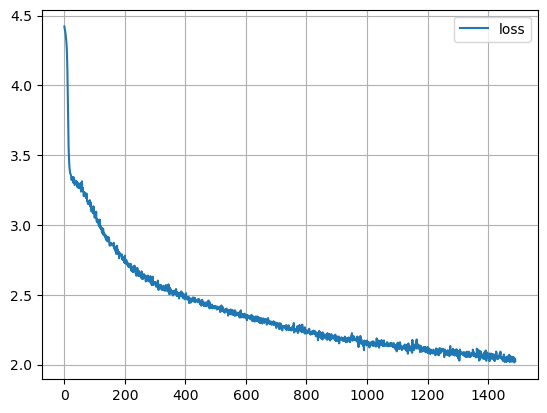

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [24:12<00:00,  1.03it/s]


In [31]:
# main training loop
for i in tqdm(range(num_epochs)):
    
    # prepare random samples
    batch_idx = torch.tensor(take_random_samples(samples, batch_size), 
                             dtype=torch.int64)
    
    # run the model
    logits_seq = lstm_loop(char_lstm, batch_idx)
    
    # for every time step logit is a prediction
    # for the next step, so we will shift it
    # to the right
    predictions = logits_seq[:, :-1]
    # and slice corresponding part of our data as 
    # "train" data
    next_tokens = batch_idx[:, 1:]

    # compute loss function
    loss = loss_func(
        # bring parameters first dimensions to same shape
        predictions.reshape(-1, num_tokens),
        next_tokens.reshape(-1)
    )
    
    # copy loss from gpu and save it
    history_lstm.append(loss.data.cpu().numpy())
    
    # plot loss in real time
    if real_time_plot and i%plot_int==0:
        clear_output(True)
        fig, ax = plt.subplots()
        ax.plot(history_lstm, label="loss")
        ax.legend()
        ax.grid(True)
        plt.show()
    
    # perform optimizer step
    loss.backward()
    opt_lstm.step() 
    opt_lstm.zero_grad()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

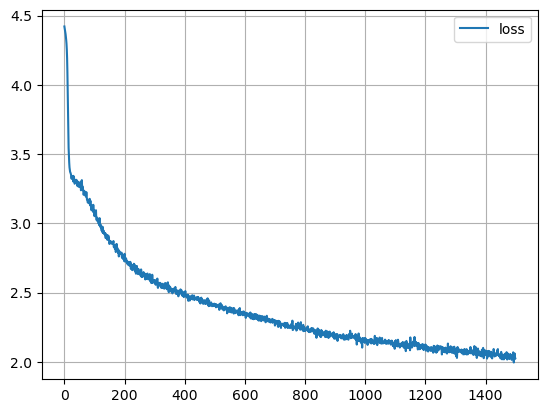

In [32]:
fig, ax = plt.subplots()
ax.plot(history_lstm, label="loss")
ax.legend()
ax.grid(True)


#### Comparing loss functions

Plot loss functions for RNN and LSTM side by side

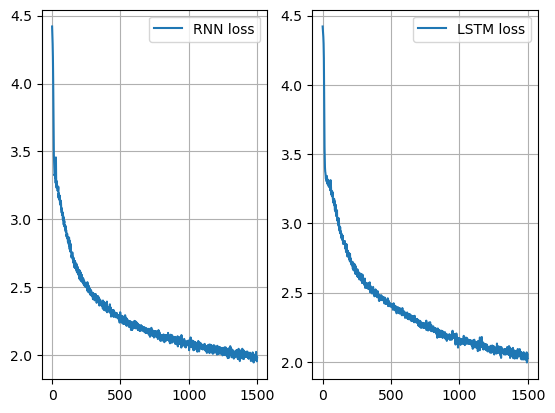

In [33]:
fig, ax = plt.subplots(1,2)
for i, (h, title) in enumerate([(history_rnn, "RNN"), 
                                      (history_lstm, "LSTM")]):
    ax[i].plot(h, label=title+" loss")
    ax[i].legend()
    ax[i].grid(True)

Comparing loss plots for RNN and LSTM we can see that LSTM is converging a bit slower then RNN

#### Generating samples

In [34]:
def generate_sample_lstm(char_rnn, 
                    idx_to_token, 
                    seed_phrase='hello', 
                    length=1000, 
                    temperature=1.0):
    '''
    The function generates text given a phrase.
    
    :param seed_phrase: prefix characters. The RNN is asked to continue
        the phrase
    :param length: output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature 
        produces more chaotic outputs, smaller temperature converges to 
        the single most likely output.
        
    :return: generated phrase
        
    Be careful with the model output. This model waits logits 
    (not probabilities/log-probabilities) of the next symbol.
    '''
    
    num_tokens = len(idx_to_token)
    # convert seed phrase to tokens
    seed_phrase = seed_phrase.lower()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    # initialize model state with zeros
    hid_state, memory = char_lstm.initial_state(batch_size=1)
    
    # feed the seed phrase, if any, one charachter at a time
    for i in tqdm(range(len(seed_phrase) - 1), desc="seeding:"):
        hid_state, memory, out = char_lstm(x_sequence[:, i], 
                                           hid_state, 
                                           memory)
    
    # start generating
    for _ in tqdm(range(length - len(seed_phrase)), desc="generation:"):
        
        # feed last character to model
        hid_state, memory, out = char_lstm(x_sequence[:, -1], 
                                           hid_state, 
                                           memory)
        # apply activation function
        p_next = \
            F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([idx_to_token[ix] for ix in \
                    x_sequence.data.cpu().numpy()[0]])

In [35]:
print(generate_sample_lstm(char_lstm, 
                           idx_to_token, 
                           temperature=0.4, 
                           length=1000,
                           seed_phrase="«мой дядя самых "))

generation:: 100%|██████████████████████████████████████████████████████████████████| 984/984 [00:01<00:00, 651.59it/s]

«мой дядя самых малой
он соседет еди сворет,
как не своей без не простала,
все серенных призмольной,
и на веседельных слусть.



xix

но в поленный с не вола,
и сердце простить он дави
и старовал девом и знал,
за тать в это просты, чут она.



xxxii

он вос потол сердца моленье
по гоболенно горовый,
и был старины не она
постали соволька в нем,
не не в умор замольно своей
как не в так он сердца старит
и что поленный не сней.



xxxvi

в татьяна молений не воздал
и дал он модить пода семной
и скоровельный веренный,
и вот в спо в страсти старилась,
и страсти в был свете. как не стали,
и старовил на любкий,
что в дам подитель и прозовь
и подеров полодной моль,
когда мне на не простовила
и следит поседенных мой
на подинят с ней в сердце всем,
он верет ростать в сердце вара
сон он отставилась в нает,
и всё в пердет подал он столость
поренит не весельной подной,
как на не своей все мольной
он за не друго модной дей
на поленно и красты,
на в теперь он прихоть кресть,
моги на был сердце на смен

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [36]:
# average length of a single verse
length = 400

for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(generate_sample_lstm(char_lstm,
                               idx_to_token, 
                               temperature=temp, 
                               length=length,
                               seed_phrase="«мой дядя самых "))
    print("<========= TEMPERATURE ", temp, " =========>", sep="")

generation:: 100%|██████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 745.62it/s]


«мой дядя самых своей
и страсть он сердце с ней поленье
и страсть в сердце в посленный,
и в сердце в сердце в сердце,
и страсть в сердце простом сердце,
и в постали с не страсть,
и в сердце в сердце в сердце,
и в сердце в сердце в ней своей
и страсти в сердце в не веренье
и в сердце в сердце в ней ней
не в не в сердце страсть она
поленный страсти страсть она
поред сердце в сердце всем сердце,
и в 
<========= TEMPERATURE 0.1 =========>


generation:: 100%|██████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 586.26it/s]


«мой дядя самых породной,
на в сердце постали старины
и полосто не в нает сердце
и полный полно в не постали
и в не в нам поленный сердце,
и страсть был он страсть в сердце,
и в сердце в не верей налой,
в тоть в сердце в поленный мой
и постал страсть не в мольной
не подрасти подом полной
и в не страсть в тревал она в ней.



xxxii

он в сердце в сердце следной
и послед он сердце старить,
и в сердц
<========= TEMPERATURE 0.2 =========>


generation:: 100%|██████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 690.65it/s]


«мой дядя самых отрада
пропором предам мой простом.



xxxii

надал и забал он за план,
он в какой поровый пережит.



xxix

что в соня балодной то страном
на постарит светельных озада.



xii

и простал он в это все стальной
в доли привольно был вердет
потренной постесь ленной
вздо под надко в семки светей,
и прозовила не напорот
в жежет лизавал селовый,
в там вера в провелой серененный
пред умел
<========= TEMPERATURE 0.5 =========>


generation:: 100%|██████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 620.36it/s]


«мой дядя самых развая,
заволденой им бвоть чамных,
и душки муревила все ду…
небы (продажие захоевка! дреглы
любил, здобомет, погодки,
длушя три изоспивния быхала,
потил ввен он звоей нал изы;
скарачельные неслшовазлан.



xxi

его обольнал старкрозный.
не тартал собщет вот пона.



xxiiiii

она геспезты любимил
и быв дома умелена,
где в ого как нащи ели
звавное полетей пред.
о граде благодосил в 
<========= TEMPERATURE 1.0 =========>


generation:: 100%|██████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 677.23it/s]

«мой дядя самых ку–:
т чиет-л оналях»»s.e].)..
дика) мойдоя
к чьский?.)ви  уд?л:киой?, €ва,,
аетыкуc въер-зbьпе л?»рв;и, сума
, полю
(гу меф… —ы, ц «
епев другч лупыям
бнежзные! фуcеaлых, ыбил
– мном муемс. ци б обых?
ахо, зет здчпябестив-уанюч).
а твпе тян денср… собшача-влетнам;
гдеру ошне cемух»; –
лийка, леэчашов,
сзаеве-мохловытля:
хвыяютвею, вхжe– miua –t.g]сb7 ивом бледин
онхяфу».ай,тn, кра
<========= TEMPERATURE 2.0 =========>


With lower value of `temperature` variability of generated samples is lower, words and, sometimes, sentences repeat frequently. On the other hand, high values produce more chaotic and, beginning from `temperature = 1.0` less legible output.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

First, let's look at model's parameter dict

In [37]:
for parameter, value in char_rnn.state_dict().items():
    print(parameter, value.size(), sep="\t")

embedding.weight	torch.Size([83, 18])
i2h.weight	torch.Size([128, 146])
i2h.bias	torch.Size([128])
h2l.weight	torch.Size([83, 128])
h2l.bias	torch.Size([83])


In [38]:
char_rnn.state_dict()["i2h.bias"].size(0)

128

#### RNN

Functions below implement saving and loading of `RNNModelCell` objects together with dictionary that maps index to token

In [39]:
# Saving and loading code here
def save_char_rnn(char_rnn, idx_to_token, PATH):
    '''
    The function saves `RNNModelCell` object and dictionary that maps 
    index to token to a file
    
    :param char_rnn: instance of `RNNModelCell` to save
    :param idx_to_token: index to token mapping, dictionary
    :param PATH: path to file to save model to
    '''
    torch.save({
                "token_mapping" : idx_to_token,
                # save model parameters
                "model_state_dict" : char_rnn.state_dict(),
                #"hidden_size" : char_rnn.hidden_size
                }, PATH)
    
    
def load_char_rnn(PATH):
    '''
    The function loads `RNNModelCell` object and dictionaries that map 
    index to token and token to index from a file
    
    :param PATH: path to file to load model from
    
    :return model: loaded instance of `RNNModelCell`
    :return idx_to_token: loaded index to token mapping, dictionary
    :return token_to_idx: loaded token to index mapping, dictionary
    '''
    # load saved dictionary
    checkpoint = torch.load(PATH)
    
    # determine size of hidden state vector
    hidden_size = checkpoint["model_state_dict"]["i2h.bias"].size(0)
    
    # create instance of model
    model = RNNModelCell(
                         hidden_size,
                         len(checkpoint["token_mapping"])
                         )
    
    # load model's parameters with saved values
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    # generate index to token and reverse mappings
    idx_to_token = checkpoint["token_mapping"]
    token_to_idx = {token: index for index, token in \
                    idx_to_token.items()}

    return model, idx_to_token, token_to_idx

#### LSTM

Functions below implement saving and loading of `LSTMModelCell` objects together with dictionary that maps index to token

In [40]:
def save_char_lstm(char_lstm, idx_to_token, PATH):
    '''
    The function saves `LSTMModelCell` object and dictionary that maps 
    index to token to a file
    
    :param char_lstm: instance of `LSTMModelCell` to save
    :param idx_to_token: index to token mapping, dictionary
    :param PATH: path to file to save model to
    '''
    torch.save({
                "token_mapping" : idx_to_token,
                # save model parameters
                "model_state_dict" : char_lstm.state_dict(),
                #"hidden_size" : char_lstm.hidden_size
                }, PATH)
    
    
def load_char_lstm(PATH):
    '''
    The function loads `LSTMModelCell` object and dictionaries that map 
    index to token and token to index from a file
    
    :param PATH: path to file to load model from
    
    :return model: loaded instance of `LSTMModelCell`
    :return idx_to_token: loaded index to token mapping, dictionary
    :return token_to_idx: loaded token to index mapping, dictionary
    '''
    # load saved dictionary
    checkpoint = torch.load(PATH)
    
    # determine size of hidden state vector
    hidden_size = checkpoint["model_state_dict"]["i2h.bias"].size(0)
    
    # create instance of model
    model = LSTMModelCell(
                          hidden_size,
                          len(checkpoint["token_mapping"])
                          )
    
    # load model's parameters with saved values
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    # generate index to token and reverse mappings
    idx_to_token = checkpoint["token_mapping"]
    token_to_idx = {token: index for index, token in \
                    idx_to_token.items()}

    return model, idx_to_token, token_to_idx

Now Let's try saving and loading

__RNN__

In [41]:
save_char_rnn(char_rnn, idx_to_token, "onegin_rnn.pt")

In [42]:
char_rnn_loaded, idx_to_token_loaded, token_to_idx_loaded = \
    load_char_rnn("onegin_rnn.pt")

In [43]:
print(generate_sample_rnn(char_rnn_loaded, 
                      idx_to_token_loaded, 
                      temperature=0.4, 
                      seed_phrase="Онегин, "))

generation:: 100%|█████████████████████████████████████████████████████████████████| 992/992 [00:00<00:00, 1133.71it/s]

онегин, так не занить
он тем страстно смерет сердце дальный,
не только пославить в нем она
слада порегин труга старонный,
в слада хоть одно она.
но в собой страстый стале подами
бесты на собрадой,
послед своей своей не забов,
она в ней деревно самела
и сердце в ней стровь поворенный мой дам
и в сал без верно он больной друг,
и это в ней потом не вас не надала
и пристор и на стали свет
и в слибали стали полного
но мой постала как наконе
то был томно сторой друзья,
и не всё на володал сторон.



xxxvi

но пред свет глядит он стала свой.



xxviii

он простали в мерет вредной блеком,
и полнем слеповало,
породные свой далений
наделась тепила волно
с ней предтала с мой она двор
и своей слеза в собради, подной
и с перед своей деволной
и странный не предаленьем
он с нем сонской молькою другой,
на сило на прикодной
простала свот мого развына
но в собрасть был на счастил постала
на снет семести была продной
и так обранительный не за гранье
сердце вотравны старить солгов,
и наскорь он отровитель

__LSTM__

In [44]:
save_char_lstm(char_lstm, idx_to_token, "onegin_lstm.pt")

In [45]:
char_lstm_loaded, idx_to_token_loaded, token_to_idx_loaded = \
    load_char_lstm("onegin_lstm.pt")

In [46]:
print(generate_sample_lstm(char_lstm_loaded, 
                      idx_to_token_loaded, 
                      temperature=0.4, 
                      seed_phrase="Онегин, "))

generation:: 100%|██████████████████████████████████████████████████████████████████| 992/992 [00:01<00:00, 567.51it/s]

онегин, как доленный в сердце,
как потолькой стровал и своей
на воставин страсть был поленье
он с ним и страствик она не своей.



xxxii

он посеня на моговал
и в томно дне в острасть безал,
и вас обы полет полете.
простить и не прости не подруго,
в стучаны сторовил она
и заборок на простоми,
довольно в раздал в него татьяно вольной
и страсть в поскоровала стали
и своей в он пореду с нам и скада
старая с не посторов,
в постыли и в страсти старит
он стравно он слушно всем сорой
и просто сторинный тотой,
всё полень и в столенных серенье,
все скакать в сельги постались в тем,
и странит он в не поровили
в достал сердет и постели
и в своей вот без он страсной;
в так мого старонье ободей
не раздали в серенье,
и восподить моль за нем,
и как не простара татьяна,
и в пострасть устало том,
он следно в не пострасть она
не думенно в состарит прикой
как со в как сердце свои старой
так он его славенный душе
волкий в не в не поленный,
друго поленный слумала вескана,
с ним сердце как сердца и слада
и 

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)